<a href="https://colab.research.google.com/github/Congyan111/STATS507/blob/main/gpt2_finetuning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPT-2 Ancient-Style Lyric Generation Project
Project Objective
Fine-tune a GPT-2 model to generate coherent and stylistically consistent ancient-style Chinese lyrics.

Model & Dataset

Pretrained Model: uer/gpt2-chinese-lyric

Dataset: chinese_poems.txt (local plain text file)

Tokenizer Type: BERT-style WordPiece (google_zh_vocab.txt)




In [3]:

%pip install -q datasets transformers accelerate torch matplotlib pandas numpy


In [4]:

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0+cu126
CUDA: False


In [5]:
from datasets import load_dataset

#load dataset
ds = load_dataset("congyanyin0623/chinese_poems.txt", split="train")

raw_lines = [item["text"] for item in ds]
print("number of lines of raw data:", len(raw_lines))

# random show raw data
import random
for i in random.sample(raw_lines, 3):
    print("\n raw data sample:", i)



chinese_poems.txt:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/304752 [00:00<?, ? examples/s]

number of lines of raw data: 304752

 raw data sample: 香在幽兰伯仲间,出尘标格自清闲.黄冠野服真相称,掠我招词赋小山.

 raw data sample: 垂鞭欲渡罗敷水,处分鸣驺且缓驱.秦氏双蛾久冥漠,苏台五马尚踟蹰.村童店女仰头笑,今日使君真是愚.

 raw data sample: 连朝幞被冷凄凄,客屐湘江到浙西.长叹故园秋渐老,快逢诗伯句频携.回廊待月来僧梵,曲径看花听鸟啼.转盼雪霜应按候,调琴协瑟念山妻.


In [6]:
import re

# data cleaning
def is_dirty_line(line):
    # include 囗 or Unicode Replacement Character �
    if "囗" in line or "�" in line:
        return True

    # Remove Rare Characters Beyond the Unicode BMP CJK Range (e.g., Extensions B/C/D/E)
    for ch in line:
        if ord(ch) > 0xFFFF:
            return True

    return False

# Remove Parenthetical Annotations
def remove_annotations(line):
    patterns = [
        r'（.*?）', r'\(.*?\)', r'【.*?】', r'〔.*?〕',
        r'《.*?》', r'「.*?」', r'『.*?』', r'〖.*?〗'
    ]
    for p in patterns:
        line = re.sub(p, '', line)
    return line.strip()

# Remove Consecutive Garbage Symbols
def remove_garbage_symbols(line):
    line = re.sub(r'[.,;:·…~!@#$%^*+=<>/\\|（）()［］\[\]{}]{2,}', '', line)
    return line.strip()

# clean each row
def clean_line(line):
    if not line.strip():
        return None

    line = remove_annotations(line)
    line = remove_garbage_symbols(line)

    # clean too short row
    if len(line) < 4:
        return None

    if is_dirty_line(line):
        return None

    return line


In [7]:
clean_poems = []
removed = 0

for line in raw_lines:
    cleaned = clean_line(line)
    if cleaned:
        clean_poems.append(cleaned)
    else:
        removed += 1

print(f"\n number of rows after cleanning: {len(clean_poems)}")
print(f"removed rows: {removed}")



 number of rows after cleanning: 295753
removed rows: 8999


In [8]:
print("\n=== Comparison Before and After Cleaning (Random 5 Lines) ===")
for raw in random.sample(raw_lines, 5):
    clean = clean_line(raw)
    print("\n row:", raw)
    print("clean:", clean if clean else "（removed）")



=== Comparison Before and After Cleaning (Random 5 Lines) ===

 row: 伐叛天威震,恢疆帝业多.削平侔肃杀,涵煦极阳和.蹈厉观周舞,风云入汉歌.功成推大定,归马偃雕戈.
clean: 伐叛天威震,恢疆帝业多.削平侔肃杀,涵煦极阳和.蹈厉观周舞,风云入汉歌.功成推大定,归马偃雕戈.

 row: 鶑啼花开春昼迟,掖庭无事方遨嬉.广平策免曲江去,十郎谈笑居台司.屏间无逸不复覩,教鸡能鬭马能舞.戏呼宁哥吹玉笛,催唤花奴打羯鼓.南衙群臣朝见疎,老伶巨珰前后趋.阿瞒半醉倚玉座,袖有曲谱无谏书.金盆皇孙真龙种,浴罢六宫竞围拥.惜哉傍有锦绷儿,蹴破咸秦跳河陇.古来治乱本无常,东封未了西幸忙.辇边贵人亦何罪,祸胎似在偃月堂.今人不识前朝事,但见断缣粧束异.岂知当日乱离人,说著开元总垂泪.
clean: 鶑啼花开春昼迟,掖庭无事方遨嬉.广平策免曲江去,十郎谈笑居台司.屏间无逸不复覩,教鸡能鬭马能舞.戏呼宁哥吹玉笛,催唤花奴打羯鼓.南衙群臣朝见疎,老伶巨珰前后趋.阿瞒半醉倚玉座,袖有曲谱无谏书.金盆皇孙真龙种,浴罢六宫竞围拥.惜哉傍有锦绷儿,蹴破咸秦跳河陇.古来治乱本无常,东封未了西幸忙.辇边贵人亦何罪,祸胎似在偃月堂.今人不识前朝事,但见断缣粧束异.岂知当日乱离人,说著开元总垂泪.

 row: 迂踈我何有,然诺君不轻.卓尔异众嗜,矧兹蔼文鸣.面壁愧空腹,伐木思友生.方当与世混,畴能别泾清.奚因一簪盍,使此双眼明.欲引万古脉,赖君辨豨苓.
clean: 迂踈我何有,然诺君不轻.卓尔异众嗜,矧兹蔼文鸣.面壁愧空腹,伐木思友生.方当与世混,畴能别泾清.奚因一簪盍,使此双眼明.欲引万古脉,赖君辨豨苓.

 row: 时康难售贾生医,谏鼓无声对落晖.又报一年花信了,满山𫛸鴂送春归.
clean: （removed）

 row: 不识阳关路,新从定远侯.黄云断春色,画角起边愁.瀚海经年到,交河出塞流.须令外国使,知饮月氏头.
clean: 不识阳关路,新从定远侯.黄云断春色,画角起边愁.瀚海经年到,交河出塞流.须令外国使,知饮月氏头.


In [9]:
from datasets import Dataset, DatasetDict

dataset_clean = Dataset.from_list([{"text": p} for p in clean_poems])
dataset_clean = dataset_clean.train_test_split(test_size=0.2, seed=42)

dataset_clean = DatasetDict({
    "train": dataset_clean["train"],
    "validation": dataset_clean["test"]
})

print(dataset_clean)
print("train size:", len(dataset_clean["train"]))
print("validation size:", len(dataset_clean["validation"]))


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 236602
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 59151
    })
})
train size: 236602
validation size: 59151


datasets stats:
total : 236602
mean: 59.32
median: 48.00
min: 4
max: 2352

Saved: 'poem_length_distribution.png'


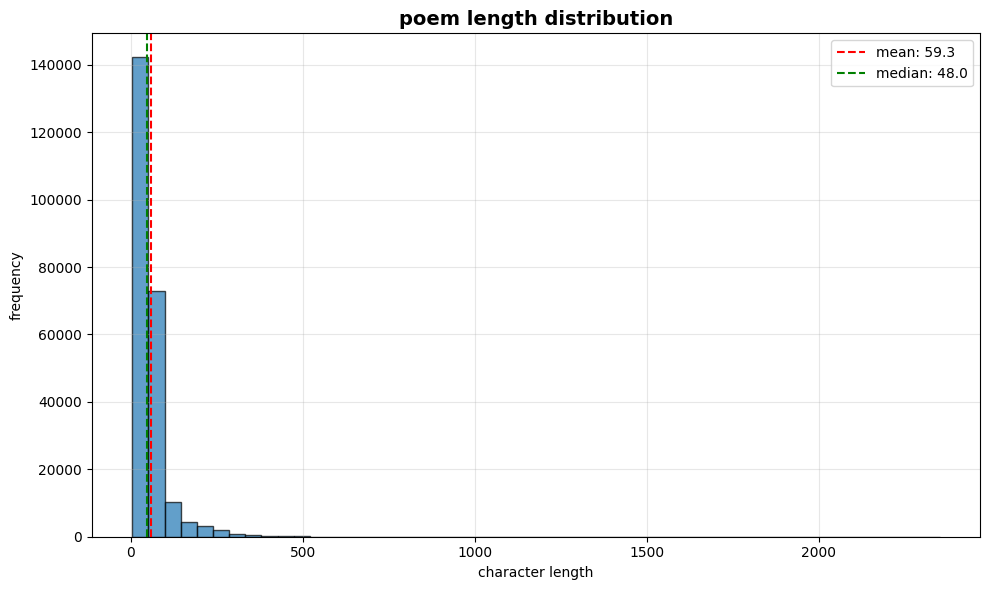

In [10]:

lengths = [len(x["text"]) for x in dataset_clean["train"]]

print("datasets stats:")
print(f"total : {len(dataset_clean['train'])}")
print(f"mean: {np.mean(lengths):.2f}")
print(f"median: {np.median(lengths):.2f}")
print(f"min: {np.min(lengths)}")
print(f"max: {np.max(lengths)}")

plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title("poem length distribution", fontsize=14, fontweight='bold')
plt.xlabel("character length")
plt.ylabel("frequency")

plt.axvline(np.mean(lengths), color='red', linestyle='--',
            label=f'mean: {np.mean(lengths):.1f}')
plt.axvline(np.median(lengths), color='green', linestyle='--',
            label=f'median: {np.median(lengths):.1f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('poem_length_distribution.png', dpi=300, bbox_inches='tight')

print("\nSaved: 'poem_length_distribution.png'")
plt.show()



In [11]:
# Load tokenizer
# Note: Use the BERT-style WordPiece tokenizer included with the model (google_zh_vocab.txt)
# Not SentencePiece
tokenizer = AutoTokenizer.from_pretrained("uer/gpt2-chinese-lyric", trust_remote_code=True)

tokenizer.eos_token = tokenizer.sep_token

# ★★★ padding [sep]
tokenizer.pad_token = tokenizer.eos_token

print(f"vocab size: {len(tokenizer)}")
print(f"Tokenizer class: {type(tokenizer).__name__}")
print(f"Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")

# testing tokenizer
test_text = dataset_clean["train"][0]["text"]
tokens = tokenizer(test_text, return_tensors="pt")
print(f"\n test sample: {test_text[:50]}...")
print(f"Token number: {tokens['input_ids'].shape[1]}")
print(f"top 10 tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0][:10])}")


tokenizer_config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

vocab size: 21128
Tokenizer class: BertTokenizerFast
Pad token: [SEP] (ID: 102)
EOS token: [SEP] (ID: 102)

 test sample: 春过湘江渡,真观八景图.云藏岳麓寺,江入洞庭湖.晴日花争发,丰年酒易沽.长沙十万户,游女似京都....
Token number: 50
top 10 tokens: ['[CLS]', '春', '过', '湘', '江', '渡', ',', '真', '观', '八']


In [12]:

# Correct data preprocessing function
# Use tokenizer to automatically generate input_ids and attention_mask
def preprocess(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# implemention
tokenized_ds = dataset_clean.map(
    preprocess,
    batched=True,
    remove_columns=dataset_clean["train"].column_names
)

print(f"\nTokenization finished！")
print(f"train size: {len(tokenized_ds['train'])}")
print(f"validation size: {len(tokenized_ds['validation'])}")
print(f"Training Set Fields: {list(tokenized_ds['train'][0].keys())}")

# show first sample
sample = tokenized_ds['train'][0]
print(f"\n first sample detail:")
print(f"  input_ids length: {len(sample['input_ids'])}")
print(f"  attention_mask length: {len(sample['attention_mask'])}")
print(f"  number of valid: {sum(sample['attention_mask'])}")
print(f"  top 10 input_ids: {sample['input_ids'][:10]}")
print(f"  top 10 attention_mask: {sample['attention_mask'][:10]}")


Map:   0%|          | 0/236602 [00:00<?, ? examples/s]

Map:   0%|          | 0/59151 [00:00<?, ? examples/s]


Tokenization finished！
train size: 236602
validation size: 59151
Training Set Fields: ['input_ids', 'token_type_ids', 'attention_mask']

 first sample detail:
  input_ids length: 128
  attention_mask length: 128
  number of valid: 50
  top 10 input_ids: [101, 3217, 6814, 3960, 3736, 3941, 117, 4696, 6225, 1061]
  top 10 attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [13]:
# Create Data Collator
# GPT2 is an autoregressive model, use mlm=False (not a masked language model)
# DataCollatorForLanguageModeling will automatically:
# 1. Shift input_ids right by one position to use as labels
# 2. Set the label at the first position to -100 (ignore loss)
# 3. Set labels at padding positions to -100 (ignore padding loss)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # False（causal LM）
)

print("DataCollator finished！")

# testing
print("\n test DataCollator:")
test_batch = [tokenized_ds['train'][i] for i in range(2)]
collated = data_collator(test_batch)
print(f"Batch keys: {collated.keys()}")
print(f"input_ids shape: {collated['input_ids'].shape}")
print(f"attention_mask shape: {collated['attention_mask'].shape}")
print(f"labels shape: {collated['labels'].shape}")
print(f"number of -100 in labels: {(collated['labels'] == -100).sum().item()}")
print(f"number of valid tokens in labels : {(collated['labels'] != -100).sum().item()}")


DataCollator finished！

 test DataCollator:
Batch keys: KeysView({'input_ids': tensor([[ 101, 3217, 6814, 3960, 3736, 3941,  117, 4696, 6225, 1061, 3250, 1745,
          119,  756, 5966, 2277, 7926, 2191,  117, 3736, 1057, 3822, 2431, 3959,
          119, 3252, 3189, 5709,  751, 1355,  117,  705, 2399, 6983, 3211, 3782,
          119, 7270, 3763, 1282,  674, 2787,  117, 3952, 1957,  849,  776, 6963,
          119,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,  102,
          102,  102,  102,  102,  102,  102,  102,  102],
        [ 101, 1921, 6804, 2145, 7027,  758, 6816, 11

In [14]:
# load model
model = AutoModelForCausalLM.from_pretrained("uer/gpt2-chinese-lyric", trust_remote_code=True)

# set pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

print(f"model type: {type(model)}")
print(f"number of model param: {sum(p.numel() for p in model.parameters()):,}")
print(f"Pad token ID: {model.config.pad_token_id}")


pytorch_model.bin:   0%|          | 0.00/421M [00:00<?, ?B/s]

model type: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>
number of model param: 102,068,736
Pad token ID: 102


In [ ]:
# set model superparam
output_dir = "./gpt2-poem"
logging_dir = "./logs"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    warmup_steps=100,
    logging_dir=logging_dir,
    logging_steps=50,

    eval_strategy="steps",
    eval_steps=2000,

    save_strategy="steps",
    save_steps=2000,

    save_total_limit=3,
    load_best_model_at_end=True,

    fp16=True,
    report_to="tensorboard",
)


In [ ]:
# trainner
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"] if "validation" in tokenized_ds else None,
    data_collator=data_collator
)



trainer.train()

print("\n finished trained！")


model.safetensors:   0%|          | 0.00/421M [00:00<?, ?B/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
2000,4.700500,4.595997
4000,4.531900,4.410470
6000,4.412400,4.305508
8000,4.332100,4.239636
10000,4.263300,4.189985
12000,4.248300,4.151513
14000,4.148500,4.113476
16000,4.089700,4.089581
18000,4.073700,4.069121
20000,4.078700,4.045791


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



 finished trained！


In [17]:
# # save model
model_save_path = "gpt2-poem-best"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)


# load model
fine_tuned_model = AutoModelForCausalLM.from_pretrained(model_save_path, trust_remote_code=True)
fine_tuned_tokenizer = AutoTokenizer.from_pretrained(model_save_path, trust_remote_code=True)

fine_tuned_tokenizer.eos_token = fine_tuned_tokenizer.sep_token

# pad_token = eos_token
fine_tuned_tokenizer.pad_token = fine_tuned_tokenizer.eos_token
fine_tuned_model.config.pad_token_id = fine_tuned_tokenizer.pad_token_id

print(f"Pad token: {fine_tuned_tokenizer.pad_token} (ID: {fine_tuned_tokenizer.pad_token_id})")
print(f"EOS token: {fine_tuned_tokenizer.eos_token} (ID: {fine_tuned_tokenizer.eos_token_id})")


OSError: gpt2-poem-best is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

Inference (Generating Ancient Poetry)
Supports multiple decoding strategies:

greedy (greedy decoding)

beam search (beam search)

top-k (Top-k sampling)

top-p (Top-p nucleus sampling)

top-p + temperature (combined sampling)

repetition_penalty (repetition penalty)

In [18]:
def generate_text(prompt, model=None, tokenizer=None, max_length=80, **kwargs):

    if model is None:
        model = fine_tuned_model
    if tokenizer is None:
        tokenizer = fine_tuned_tokenizer


    inputs = tokenizer(prompt, return_tensors="pt")


    device = next(model.parameters()).device
    input_ids = inputs['input_ids'].to(device)


    gen_kwargs = {
        'max_length': max_length,
        'pad_token_id': tokenizer.eos_token_id,
        'eos_token_id': tokenizer.eos_token_id,
    }
    gen_kwargs.update(kwargs)


    with torch.no_grad():
        outputs = model.generate(input_ids, **gen_kwargs)


    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

test_prompt = "春风"
result = generate_text(test_prompt, do_sample=True, top_p=0.9, temperature=0.7)
print(f"prompt: {test_prompt}")
print(f"result: {result}")


NameError: name 'fine_tuned_model' is not defined

In [ ]:
# promot
test_prompts = ["春风", "明月", "山水", "江南"]

print("=" * 80)
print("comparison")
print("=" * 80)

# Greedy
print("\n【Greedy】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=False)
    print(f"\prompt: {prompt}")
    print(f"result: {generated}")
    print()


comparison

【Greedy】
--------------------------------------------------------------------------------
\prompt: 春风
result: 春 风, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格. 春 风 格, 春 风 格

\prompt: 明月
result: 明 月, 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊, 明 月 姊. 明 月 姊

\prompt: 山水
result: 山 水, 水 石. 水 石, 山 水. 山 水, 水 石. 山 水, 山 水. 山 水, 山 水. 山 水, 山 水. 山 水, 山 水. 山 水, 山 水. 山 水, 山 水. 山 水, 山 水

\prompt: 江南
result: 江 南, 江 北. 江 北 江 北, 江 北 江 北. 江 北 江 北, 江 北 江 北. 江 北 江 北, 江 北 江 北. 江 北 江 北, 江 北 江 北. 江 北 江 北, 江 北 江 北. 江 北 江 北, 江 北 江 北. 江 北 江 北, 江 北 江 北. 江 北



In [25]:
# Beam Search
print("\n【Beam Search】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, num_beams=5, do_sample=False)
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()



【Beam Search】
--------------------------------------------------------------------------------


NameError: name 'test_prompts' is not defined

In [24]:
# Top-k=50
print("\n【Top-k=50】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=True, top_k=50, temperature=1.0)
    print(f"\n promot: {prompt}")
    print(f" result: {generated}")
    print()



【Top-k=50】
--------------------------------------------------------------------------------


NameError: name 'test_prompts' is not defined

In [23]:
# Top-p=0.9
print("\n【Top-p=0.9】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=True, top_p=0.9, temperature=1.0)
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()



【Top-p=0.9】
--------------------------------------------------------------------------------


NameError: name 'test_prompts' is not defined

In [ ]:
# Top-p=0.9 + temperature=0.7
print("\n【Top-p=0.9 + temperature=0.7】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(prompt, do_sample=True, top_p=0.9, temperature=0.7)
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()



【Top-p=0.9 + temperature=0.7】
--------------------------------------------------------------------------------

 prompt: 春风
result: 春 风 咿 春 风,. 春 风 一 日 不 自 惜, 秋 风 万 里 如 飞. 黄 花 白 草 空 自 芳, 春 风 万 里 无 寸 长. 春 风 一 日 不 自 惜, 花 落 花 开 空 自 伤. 春 风 万 里 万 里 长, 春 风 万 里 千 里 长


 prompt: 明月
result: 明 月, 秋 风 筝 弦 清. 秋 风 筝 声 清, 秋 风 筝 意 苦. 三 十 六 弦 成 一 曲, 一 曲 三 曲 尽 人 意, 曲 尽 心 成 曲 尽 处. 曲 尽 心, 终 不 能 成, 心 不 能 成 曲 尽 尽. 曲 尽 曲, 曲 尽 曲, 曲 尽 曲. 曲 尽 曲,


 prompt: 山水
result: 山 水 坤, 山 水. 有 时 雨, 有 时 风. 有 时, 有 时. 有 时, 有 时 钟. 有 时 钟, 有 时 钟. 有 时 松, 有 时 松. 有 时 钟, 有 时 松. 有 时 松, 有 时 松. 有 时 松, 有 时 松. 有 时 松, 有


 prompt: 江南
result: 江 南, 江 南. 江 北 江 南. 江 南 江 北. 江 南 江 北. 江 北 江 北. 水 上 有 沙, 沙 上 有 沙. 沙 上 有 沙, 沙 下 有 沙. 沙 上 有 沙, 沙 下 有 沙. 沙 下 有 沙, 沙 上 有 沙. 沙 下 有 沙, 沙 上 有 沙. 沙 上



In [22]:

print("\n【Top-p=0.9 + temperature=0.7 + repetition_penalty=1.2】")
print("-" * 80)
for prompt in test_prompts:
    generated = generate_text(
        prompt,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.2
    )
    print(f"\n prompt: {prompt}")
    print(f"result: {generated}")
    print()



【Top-p=0.9 + temperature=0.7 + repetition_penalty=1.2】
--------------------------------------------------------------------------------


NameError: name 'test_prompts' is not defined

In [21]:
# evaluate
strategies = {
    'Greedy': {'do_sample': False},
    'Beam Search': {'num_beams': 5, 'do_sample': False},
    'Top-k=50': {'do_sample': True, 'top_k': 50, 'temperature': 1.0},
    'Top-p=0.9': {'do_sample': True, 'top_p': 0.9, 'temperature': 1.0},
    'Top-p=0.9+Temp=0.7': {'do_sample': True, 'top_p': 0.9, 'temperature': 0.7},
}

# result
all_results = {}
for strategy_name, params in strategies.items():
    print(f"\n stratigy: {strategy_name}")
    results = []
    for prompt in test_prompts:
        generated = generate_text(prompt, **params)
        generated_only = generated[len(prompt):].strip()
        results.append({
            'prompt': prompt,
            'generated': generated,
            'generated_only': generated_only,
            'length': len(generated_only),
            'line_count': generated_only.count('\n')
        })
    all_results[strategy_name] = results




 stratigy: Greedy


NameError: name 'test_prompts' is not defined

In [ ]:
comparison_data = []
for strategy_name, results in all_results.items():
    for result in results:
        comparison_data.append({
            'stratigy': strategy_name,
            'prompt': result['prompt'],
            'length': result['length'],
            'result': result['generated_only'][:10] + '...' if len(result['generated_only']) > 60 else result['generated_only']
        })

df_comparison = pd.DataFrame(comparison_data)
print("\n comparison")
print(df_comparison.to_string(index=False))



 comparison
          stratigy prompt  length        result
            Greedy     春风     134 风, 春 风 格. ...
            Greedy     明月     134 月, 明 月 姊, ...
            Greedy     山水      96 水, 水 石. 水 ...
            Greedy     江南     137 南, 江 北. 江 ...
       Beam Search     春风     134 风, 春 风 醇. ...
       Beam Search     明月     134 月, 明 月 姊, ...
       Beam Search     山水      78 水 坤, 水 石. ...
       Beam Search     江南     137 南, 江 北, 江 ...
          Top-k=50     春风     137 风. 草 色 青 苍...
          Top-k=50     明月     137 月 成 碧 玉, 晴...
          Top-k=50     山水     135 水 纭, 文 章 笔...
          Top-k=50     江南     138 南. 江 北 杭, ...
         Top-p=0.9     春风     136 风 艋 城, 水 际...
         Top-p=0.9     明月     144 月, 金 波 潋 滟...
         Top-p=0.9     山水     134 水 纭 不 相 似,...
         Top-p=0.9     江南     141 南 么, 江 北 岸...
Top-p=0.9+Temp=0.7     春风     134 风 何 太 早, 白...
Top-p=0.9+Temp=0.7     明月     143 月, 明 月 皎 皎...
Top-p=0.9+Temp=0.7     山水     123 水, 洞 庭 山. ...
Top-p=0.9+Temp=0.7     江南  

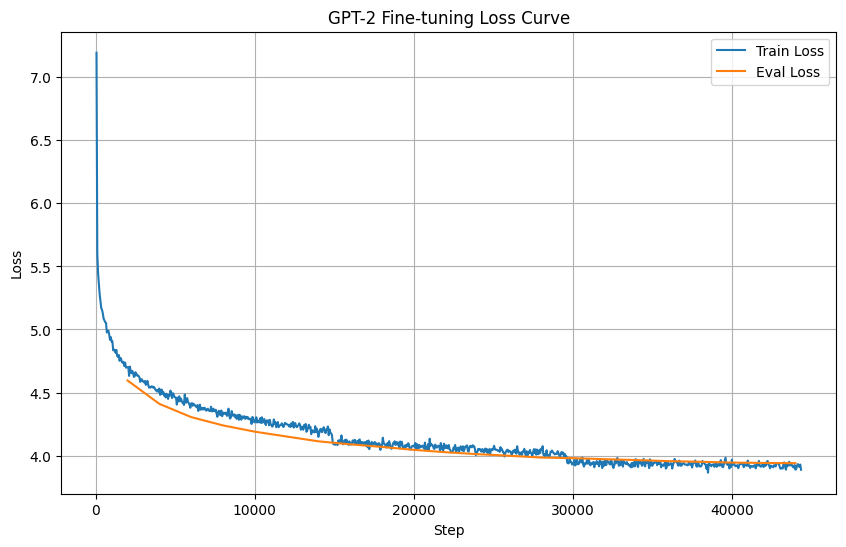

In [ ]:
import json
import matplotlib.pyplot as plt

state_file = "/content/gpt2-poem/checkpoint-44364/trainer_state.json"

with open(state_file, "r") as f:
    state = json.load(f)

log_history = state["log_history"]

train_steps = []
train_loss = []

eval_steps = []
eval_loss = []

for entry in log_history:
    if "loss" in entry and "learning_rate" in entry:
        train_steps.append(entry["step"])
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_loss.append(entry["eval_loss"])

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("GPT-2 Fine-tuning Loss Curve")
plt.legend()
plt.grid()
plt.show()


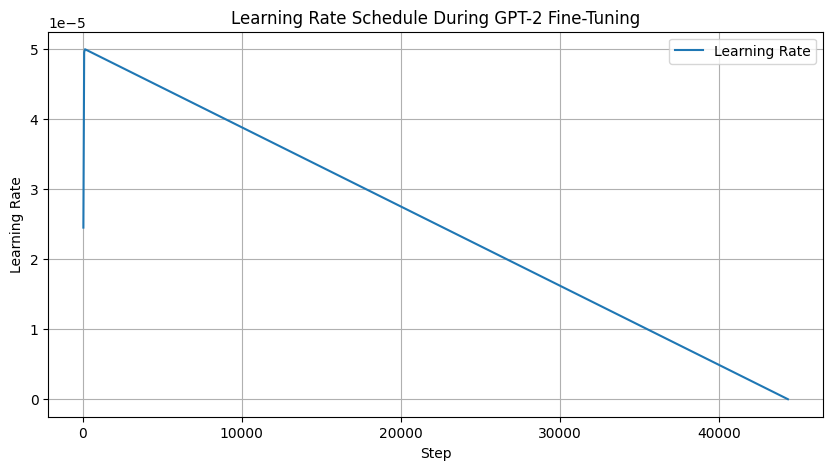

In [ ]:
import json
import matplotlib.pyplot as plt


ckpt_path = "./gpt2-poem/checkpoint-44364"

state_file = f"{ckpt_path}/trainer_state.json"


with open(state_file, "r") as f:
    state = json.load(f)

logs = state["log_history"]

steps = []
lrs = []

for entry in logs:
    if "learning_rate" in entry:
        lrs.append(entry["learning_rate"])
        steps.append(entry.get("step", None))


plt.figure(figsize=(10,5))
plt.plot(steps, lrs, label="Learning Rate")
plt.title("Learning Rate Schedule During GPT-2 Fine-Tuning")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()
